In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv("bank_data.csv")
data.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


In [2]:
data.isnull().sum().sum()

0

# Graphical exploratory data analysis

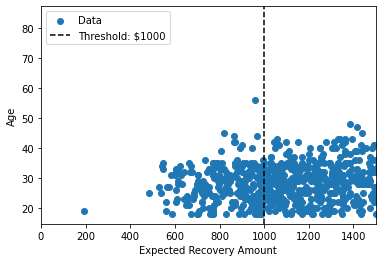

In [3]:
x = data.expected_recovery_amount
y = data.age
threshold = 1000

# Plot the data points
plt.scatter(x, y, label='Data')

# Plot the threshold as a vertical line
plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold: $1000')

plt.xlabel('Expected Recovery Amount')
plt.ylabel('Age')
plt.xlim(0, 1500)
plt.legend()
plt.show()

# Statistical test: age vs. expected recovery amount

In [4]:
# Import stats module
from scipy import stats

df_900_1100 = data.loc[(data['expected_recovery_amount'] < 1100) & (data['expected_recovery_amount'] >= 900)]

# Perform t-test
Level_0 = df_900_1100.loc[data['recovery_strategy'] == 'Level 0 Recovery']['age']
Level_1 = df_900_1100.loc[data['recovery_strategy'] == 'Level 1 Recovery']['age']
stats.kruskal(Level_0, Level_1)


KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

the p-value (0.06297556896097407) is greater than the alpha of 0.05. This suggests that there is not enough evidence to reject the null hypothesis, meaning that there is no significant difference between the means of the 'Level 0 Recovery' and 'Level 1 Recovery' groups in terms of age.

# Statistical test: sex vs. expected recovery amount

In [5]:
# Create contingency table for sex and recovery amount
contingency_table = pd.crosstab(data['sex'],data.loc[(data['expected_recovery_amount']<1100) & (data['expected_recovery_amount']>=900)]['recovery_strategy'])

# Perform chi-square test
chi2_stat, p_value, dof, ex = stats.chi2_contingency(contingency_table)

# Print the chi-square statistic and p-value
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)

Chi-square statistic: 0.3796422112341753
P-value: 0.5377947810444592


Based on these results, we do not have enough evidence to conclude that there is a significant association between the variables being tested. The observed differences in the contingency table could be due to random chance rather than a true association.

# Exploratory graphical analysis: recovery amount

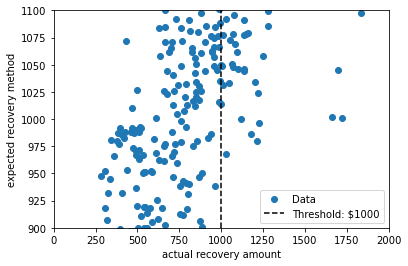

In [6]:
x=data.actual_recovery_amount
y=data.expected_recovery_amount

# Plot the data points
plt.scatter(x, y, label='Data')

# Plot the threshold as a vertical line
plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold: $1000')

plt.xlabel('actual recovery amount')
plt.ylabel('expected recovery method')
plt.ylim(900, 1100)
plt.xlim(0,2000)
plt.legend()
plt.show()

# Statistical analysis: recovery amount

In [7]:
df_900_1100 = data.loc[(data['expected_recovery_amount'] < 1100) & (data['expected_recovery_amount'] >= 900)]
df_950_1050 = data.loc[(data['expected_recovery_amount'] < 1050) & (data['expected_recovery_amount'] >= 950)]

# Perform t-test
Level_0 = df_900_1100.loc[data['recovery_strategy'] == 'Level 0 Recovery']['actual_recovery_amount']
Level_1 = df_900_1100.loc[data['recovery_strategy'] == 'Level 1 Recovery']['actual_recovery_amount']
stats1=stats.kruskal(Level_0, Level_1)
Level_0_d = df_950_1050.loc[data['recovery_strategy'] == 'Level 0 Recovery']['actual_recovery_amount']
Level_1_d = df_950_1050.loc[data['recovery_strategy'] == 'Level 1 Recovery']['actual_recovery_amount']
stats2=stats.kruskal(Level_0_d, Level_1_d)
print("for 900_1100", stats1)
print("for 950_1050", stats2)


for 900_1100 KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)
for 950_1050 KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)


# Regression modeling: no threshold

In [8]:
import statsmodels.api as sm

X = df_900_1100['expected_recovery_amount']
y = df_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Mon, 17 Jul 2023   Prob (F-statistic):           1.56e-13
Time:                            20:19:39   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Regression modeling: adding true threshold

In [12]:
data['indicator_1000'] = np.where(data['expected_recovery_amount'] < 1000, 0, 1)

# Define X and y
X = data[['expected_recovery_amount', 'indicator_1000']]
y = data['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.819
Model:                                OLS   Adj. R-squared:                  0.818
Method:                     Least Squares   F-statistic:                     4241.
Date:                    Mon, 17 Jul 2023   Prob (F-statistic):               0.00
Time:                            20:30:27   Log-Likelihood:                -16926.
No. Observations:                    1882   AIC:                         3.386e+04
Df Residuals:                        1879   BIC:                         3.387e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

# Regression modeling: adjusting the window

In [15]:
df_950_1050 = data.loc[(data['expected_recovery_amount']<1050) & (data['expected_recovery_amount']>=950)]

# Define X and y
X = df_950_1050[['expected_recovery_amount','indicator_1000']]
y = df_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Mon, 17 Jul 2023   Prob (F-statistic):           1.12e-07
Time:                            20:35:29   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""